# RDW Market Cap Explorer

RDW_API_graphs.py re written again in a Notebook for consistency

In [17]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression

Inputs

In [2]:
#This is hard - coded, no input from the putside.
# explanatory
merk = "BMW"
handelsbenaming = "118i"
keys = ["catalogusprijs", "datum_eerste_tenaamstelling_in_nederland", "datum_tenaamstelling"]


API call

In [3]:
url = f"https://opendata.rdw.nl/resource/m9d7-ebf2.json?merk={merk}&handelsbenaming={handelsbenaming}"
response = requests.get(url)
data = response.json()

Convert to DataFrame

In [4]:
df = pd.DataFrame(data)

# Fill missing keys with None
for k in keys:
    if k not in df.columns:
        df[k] = None

df

,kenteken,voertuigsoort,merk,handelsbenaming,vervaldatum_apk,datum_tenaamstelling,bruto_bpm,inrichting,aantal_zitplaatsen,eerste_kleur,...,hoogte_voertuig,registratie_datum_goedkeuring_afschrijvingsmoment_bpm,registratie_datum_goedkeuring_afschrijvingsmoment_bpm_dt,api_gekentekende_voertuigen_assen,api_gekentekende_voertuigen_brandstof,api_gekentekende_voertuigen_carrosserie,api_gekentekende_voertuigen_carrosserie_specifiek,api_gekentekende_voertuigen_voertuigklasse,zuinigheidsclassificatie,plaats_chassisnummer
0,X053GK,Personenauto,BMW,118i,20270527,20240105,2340,hatchback,5,ZWART,...,143,20231026,2023-10-26T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
1,X148VF,Personenauto,BMW,118i,20261218,20250519,1847,hatchback,5,GRIJS,...,143,20240124,2024-01-24T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
2,Z480NV,Personenauto,BMW,118i,20271029,20240525,4388,hatchback,5,ZWART,...,143,20240514,2024-05-14T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
3,HPL31S,Personenauto,BMW,118i,20251216,20250516,3322,hatchback,5,GRIJS,...,143,20250417,2025-04-17T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
4,T643TG,Personenauto,BMW,118i,20270522,20231031,4466,hatchback,5,ZWART,...,143,20230822,2023-08-22T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,T901TG,Personenauto,BMW,118i,20271115,20230928,4957,hatchback,5,GRIJS,...,143,20230822,2023-08-22T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
314,X898HT,Personenauto,BMW,118i,20271130,20241116,1787,hatchback,5,GRIJS,...,143,20231108,2023-11-08T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
315,R368KH,Personenauto,BMW,118i,20270428,20231005,2532,hatchback,5,WIT,...,143,20220920,2022-09-20T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN
316,Z362NZ,Personenauto,BMW,118i,20260529,20240601,2218,hatchback,5,ZWART,...,143,20240430,2024-04-30T00:00:00.000,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN,NaN


cleaning of the dataset by converting price and date columns to numeric and datetime formats, removing invalid or missing entries, and filtering out cars with unrealistic prices.

In [5]:
df['catalogusprijs'] = pd.to_numeric(df['catalogusprijs'], errors='coerce')  # coerce invalid to NaN
df['datum_eerste_tenaamstelling_in_nederland'] = pd.to_datetime(df['datum_eerste_tenaamstelling_in_nederland'], errors='coerce', format='%Y%m%d')
df['datum_tenaamstelling'] = pd.to_datetime(df['datum_tenaamstelling'], errors='coerce', format='%Y%m%d')

# Drop rows with missing catalogusprijs or datum_tenaamstelling
df = df.dropna(subset=['catalogusprijs', 'datum_tenaamstelling'])

# Optional: filter out extremely large/unrealistic catalogusprijs
df = df[df['catalogusprijs'] < 1e7]

Create Occassion Dummy

In [6]:
df['Occasion'] = np.where(
    df['datum_eerste_tenaamstelling_in_nederland'] != df['datum_tenaamstelling'], 1, 0
)

Extract year

In [9]:
df['year'] = df['datum_tenaamstelling'].dt.year
df = df.dropna(subset=['year'])

Computing Statistics: avg, count records per year, market cap

In [7]:
avg_price = df.groupby('Occasion')['catalogusprijs'].mean()
avg_new = avg_price.get(0, np.nan)
avg_occ = avg_price.get(1, np.nan)
print(f"Average catalogusprijs New: {avg_new:.2f}")
print(f"Average catalogusprijs Occasion: {avg_occ:.2f}")

Average catalogusprijs New: 44382.22
Average catalogusprijs Occasion: 44409.23


In [10]:
counts = df.groupby(['year', 'Occasion']).agg(
    count=('catalogusprijs','size'),
    avg_price=('catalogusprijs','mean')
).reset_index()

counts['market_cap'] = counts['count'] * counts['avg_price']

In [28]:
print(counts['year'].min(), counts['year'].max())

2022 2025


Forecasting of market trends for new and used cars over the next five years, achieved by applying linear regression to past yearly data and projecting future values based on the fitted trend.

In [11]:
last_year = counts['year'].max()
forecast_years = np.arange(last_year + 1, last_year + 6)

# LR separately for New and Occasion
forecast_dfs = []
for occ in [0,1]:
    sub = counts[counts['Occasion']==occ]
    if len(sub) > 1:  # need at least 2 points for regression
        model = LinearRegression()
        model.fit(sub[['year']], sub['market_cap'])
        pred = model.predict(forecast_years.reshape(-1,1))
        df_forecast = pd.DataFrame({
            'year': forecast_years,
            'Occasion': occ,
            'market_cap': pred,
            'count': np.nan
        })
        forecast_dfs.append(df_forecast)

forecast_df = pd.concat(forecast_dfs, ignore_index=True)
plot_df = pd.concat([counts, forecast_df], ignore_index=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [13]:
# Map labels for clearer interpretation in the data.
plot_df['Type'] = plot_df['Occasion'].map({0:'New', 1:'Occasion'})

To compare results, the same forecasting process is repeated using a Logistic Regression model. This allows evaluating how a nonlinear, probability-based model performs relative to the linear regression in predicting future market trends for new and used cars.

In [18]:
forecast_dfs_log = []
for occ in [0, 1]:
    sub = counts[counts['Occasion'] == occ]
    if len(sub) > 1:  # need at least 2 points
        model = LogisticRegression(max_iter=1000)
        # Fit model on scaled years (for stability)
        X = sub[['year']]
        y = (sub['market_cap'] > sub['market_cap'].median()).astype(int)  # binary transformation
        model.fit(X, y)

        # Predict probabilities for future years
        probs = model.predict_proba(forecast_years.reshape(-1, 1))[:, 1]

        df_forecast = pd.DataFrame({
            'year': forecast_years,
            'Occasion': occ,
            'market_cap': probs * sub['market_cap'].max(),  # rescale to compare with LR
            'count': np.nan
        })
        forecast_dfs_log.append(df_forecast)

forecast_df_log = pd.concat(forecast_dfs_log, ignore_index=True)

# Combine historical + logistic forecast data
plot_df_log = pd.concat([counts, forecast_df_log], ignore_index=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [20]:
plot_df_log['Type'] = plot_df['Occasion'].map({0:'New', 1:'Occasion'})

###Plots

Linear regression

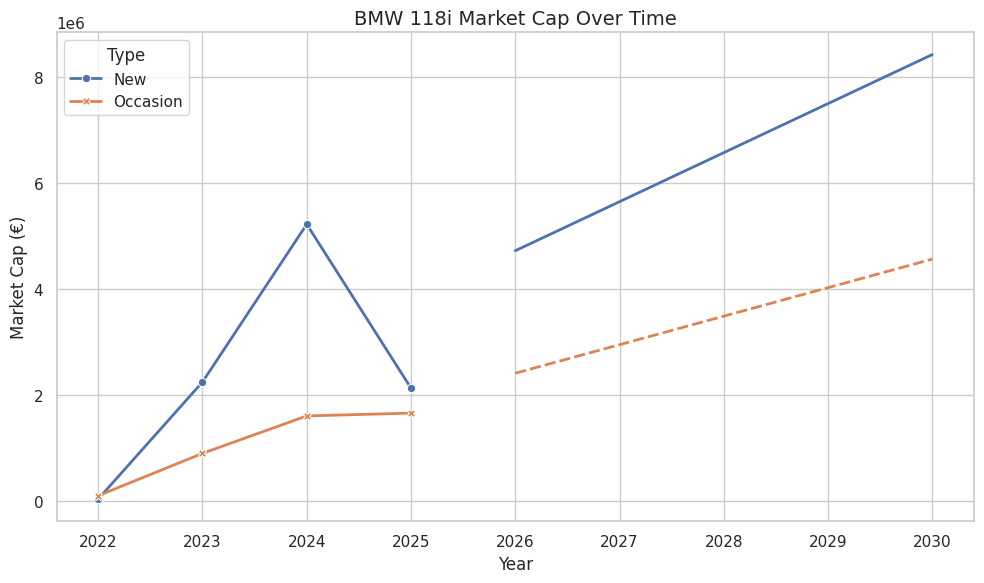

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

#historical data
sns.lineplot(
    data=plot_df[~plot_df['year'].isin(forecast_df['year'])],
    x='year', y='market_cap', hue='Type', style='Type',
    markers=True, dashes=False, linewidth=2
)

#forecast data as dotted lines
sns.lineplot(
    data=forecast_df.merge(plot_df[['Type', 'Occasion']].drop_duplicates(), on='Occasion'),
    x='year', y='market_cap', hue='Type', style='Type',
    linewidth=2, linestyle='dotted', legend=False
)

plt.title(f"{merk} {handelsbenaming} Market Cap Over Time", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Market Cap (€)")
plt.legend(title="Type")

plt.tight_layout()
plt.show()

Logistic Regression

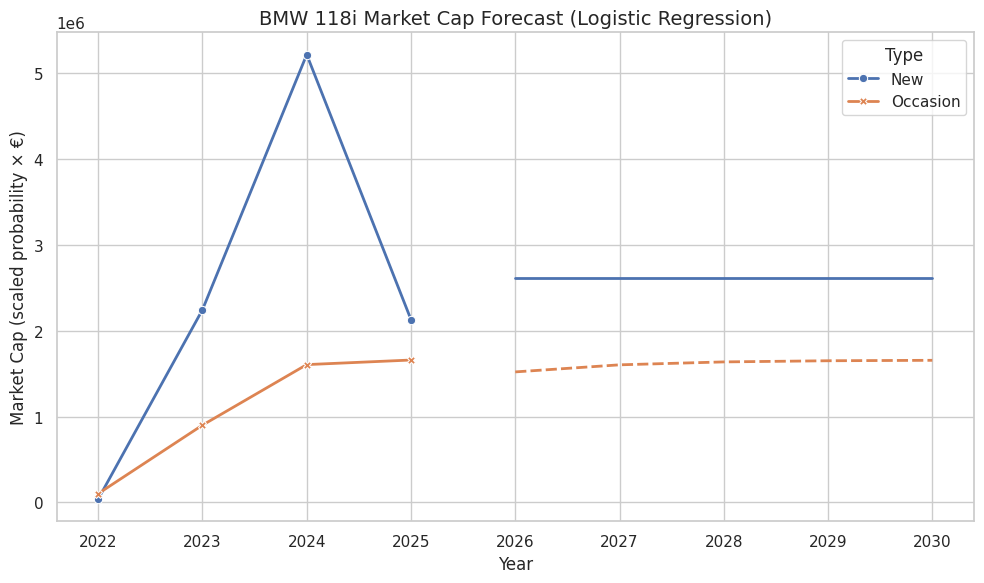

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Historical data
sns.lineplot(
    data=plot_df_log[~plot_df_log['year'].isin(forecast_df_log['year'])],
    x='year', y='market_cap', hue='Type', style='Type',
    markers=True, dashes=False, linewidth=2
)

# Forecast data as dotted lines
sns.lineplot(
    data=forecast_df_log.merge(plot_df_log[['Type', 'Occasion']].drop_duplicates(), on='Occasion'),
    x='year', y='market_cap', hue='Type', style='Type',
    linewidth=2, linestyle='dotted', legend=False
)

plt.title(f"{merk} {handelsbenaming} Market Cap Forecast (Logistic Regression)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Market Cap (scaled probability × €)")
plt.legend(title="Type")

plt.tight_layout()
plt.show()


I would personally choose the Logistic because it appears to me to be more accurate. Moreover

## A Streamlit app

Version for the Streamilit app that fetches vehicle data from the RDW API, compares new vs. occasion cars, and forecasts market trends using linear regression.

It visualizes yearly market capitalization in an interactive Plotly chart.

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import streamlit as st
import plotly.express as px
from sklearn.linear_model import LogisticRegression

In [24]:
RDW_ENDPOINT = "https://opendata.rdw.nl/resource/m9d7-ebf2.json"

In [ ]:
@st.cache_data(show_spinner=False)
def fetch_rdw(merk: str, handelsbenaming: str, app_token: str | None = None) -> pd.DataFrame:
    headers = {}
    if app_token:
        headers["X-App-Token"] = app_token

    params = {
        "merk": merk,
        "handelsbenaming": handelsbenaming,
        "$limit": 50000
    }
    resp = requests.get(RDW_ENDPOINT, params=params, headers=headers, timeout=30)
    resp.raise_for_status()
    data = resp.json()
    return pd.DataFrame(data)

In [ ]:
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    needed = [
        "catalogusprijs",
        "datum_eerste_tenaamstelling_in_nederland",
        "datum_tenaamstelling",
    ]
    for k in needed:
        if k not in df.columns:
            df[k] = None

    df["catalogusprijs"] = pd.to_numeric(df["catalogusprijs"], errors="coerce")
    df["datum_eerste_tenaamstelling_in_nederland"] = pd.to_datetime(
        df["datum_eerste_tenaamstelling_in_nederland"], errors="coerce", format="%Y%m%d"
    )
    df["datum_tenaamstelling"] = pd.to_datetime(
        df["datum_tenaamstelling"], errors="coerce", format="%Y%m%d"
    )

    df = df.dropna(subset=["catalogusprijs", "datum_tenaamstelling"])
    df = df[df["catalogusprijs"] < 1e7]

    df["Occasion"] = np.where(
        df["datum_eerste_tenaamstelling_in_nederland"] != df["datum_tenaamstelling"], 1, 0
    )
    df["year"] = df["datum_tenaamstelling"].dt.year
    df = df.dropna(subset=["year"])
    return df

In [ ]:
def aggregate_market_cap(df: pd.DataFrame) -> pd.DataFrame:
    counts = df.groupby(["year", "Occasion"]).agg(
        count=("catalogusprijs","size"),
        avg_price=("catalogusprijs","mean")
    ).reset_index()
    counts["market_cap"] = counts["count"] * counts["avg_price"]
    return counts

In [ ]:
def forecast_market_cap(counts: pd.DataFrame, years_ahead: int = 5) -> pd.DataFrame:
    if counts.empty:
        return pd.DataFrame(columns=["year", "Occasion", "market_cap", "count"])
    last_year = int(counts["year"].max())
    forecast_years = np.arange(last_year + 1, last_year + years_ahead + 1)

    forecast_dfs = []
    for occ in [0, 1]:
        sub = counts[counts["Occasion"] == occ]
        if len(sub) > 1:
            model = LinearRegression()
            model.fit(sub[["year"]], sub["market_cap"])
            pred = model.predict(forecast_years.reshape(-1, 1))
            forecast_dfs.append(pd.DataFrame({
                "year": forecast_years,
                "Occasion": occ,
                "market_cap": pred,
                "count": np.nan
            }))

    if not forecast_dfs:
        return pd.DataFrame(columns=["year", "Occasion", "market_cap", "count"])
    return pd.concat(forecast_dfs, ignore_index=True)

st.set_page_config(page_title="RDW Market Cap Explorer", layout="wide")
st.title("RDW Market Cap Explorer")

with st.sidebar:
    st.header("Filters")
    merk = st.text_input("Brand (merk)", value="BMW")
    handelsbenaming = st.text_input("Model (handelsbenaming)", value="118i")
    years_ahead = st.slider("Forecast years ahead", min_value=1, max_value=10, value=5)
    st.caption("Optional: set an RDW App Token to increase rate limits.")
    default_token = os.environ.get("RDW_APP_TOKEN", "")
    app_token = st.text_input("X-App-Token (optional)", value=default_token, type="password")
    run = st.button("Run")

if run:
    try:
        raw = fetch_rdw(merk, handelsbenaming, app_token or None)
        if raw.empty:
            st.warning("No rows returned. Try different inputs or check capitalization.")
        else:
            df = prepare_dataframe(raw)
            if df.empty:
                st.warning("Rows returned but none valid after cleaning.")
            else:
                # KPIs
                avg_price = df.groupby("Occasion")["catalogusprijs"].mean()
                col1, col2 = st.columns(2)
                with col1:
                    st.metric("Average Price (New)", f"€{avg_price.get(0, np.nan):,.0f}")
                with col2:
                    st.metric("Average Price (Occasion)", f"€{avg_price.get(1, np.nan):,.0f}")

                counts = aggregate_market_cap(df)
                forecast_df = forecast_market_cap(counts, years_ahead=years_ahead)
                plot_df = pd.concat([counts, forecast_df], ignore_index=True)
                plot_df["Type"] = plot_df["Occasion"].map({0: "New", 1: "Occasion"})

                fig = px.line(
                    plot_df, x="year", y="market_cap", color="Type", line_dash="Type", markers=True,
                    title=f"{merk} {handelsbenaming} Market Cap Over Time",
                    hover_data={"year": True, "count": True, "market_cap":":.2f"}
                )
                # Add dotted forecast layers
                if not forecast_df.empty:
                    for occ in [0, 1]:
                        fsub = forecast_df[forecast_df["Occasion"] == occ]
                        if not fsub.empty:
                            fig.add_scatter(
                                x=fsub["year"], y=fsub["market_cap"], mode="lines",
                                name=f"Forecast {['New','Occasion'][occ]}", line=dict(dash="dot")
                            )
                fig.update_layout(xaxis_title="Year", yaxis_title="Market Cap (€)", hovermode="x unified")
                st.plotly_chart(fig, use_container_width=True)

                st.subheader("Aggregated Table")
                st.dataframe(counts.sort_values(["Occasion", "year"]))
    except requests.HTTPError as e:
        st.error(f"HTTP error from RDW: {e}")
    except Exception as e:
        st.exception(e)
else:
    st.info("Set inputs in the sidebar and click **Run**.")